# Trial Results and CDF

We ran tests, recording the time it took each sample to go through the pipeline, starting from when the producer sent off the sample to the broker, and ending when the producer's consumer thread saw that the sample's inference had been posted to the broker.

Varying the number of producers from 1 to 4, on the different VMs, we collected the results in the n_producer folders. The txt filename "elapsed_times_X_Y.txt" signifies that this is a trial for X number of producers, and that this txt file is the log for times from VM Y.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Function to plot the CDF for a number of producers, given all the files with that number of producers
def plotCDF(files, num_producers):
    # Read the txt file, specifying that the first row is the header
    combined_df = pd.DataFrame()
    
    for filename in files:
        df = pd.read_csv(filename, delimiter=',', header=0, names=['ID', 'ElapsedTime'])
        df = df.drop(0, axis=0) # Drop the first row, as sometimes it takes longer to connect to the consumer
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Extract the 'ElapsedTime' column (decimal values)
    values = combined_df['ElapsedTime']

    # Sort the values to prepare for the CDF
    sorted_values = np.sort(values)

    # Get the 90th and 95th percentiles
    percentile_90 = np.percentile(sorted_values, 90)
    percentile_95 = np.percentile(sorted_values, 95)

    # Calculate the cumulative distribution
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)

    # Plot the CDF using matplotlib
    plt.plot(sorted_values, cdf, marker='.', linestyle='none')

    # Plot the 90th and 95th percentiles, distinguishing them with different colors
    plt.scatter(percentile_90, 0.90, color='red', label='90th Percentile', zorder=5)
    plt.scatter(percentile_95, 0.95, color='green', label='95th Percentile', zorder=5)

    # Annotate the 90th and 95th percentiles to show exact values
    plt.annotate(f'90th: {percentile_90:.4f}', xy=(percentile_90, 0.90), 
        xytext=(percentile_90 + 0.02, 0.88),
        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5),
        fontsize=10, color='red')

    plt.annotate(f'95th: {percentile_95:.4f}', xy=(percentile_95, 0.95), 
        xytext=(percentile_95 + 0.02, 0.93),
        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5),
        fontsize=10, color='green')

    # Set the title, labels, and grid
    plt.title(f'CDF of ElapsedTime for {num_producers} Producer{"" if num_producers == 1 else "s"}')
    plt.xlabel('ElapsedTime (seconds)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

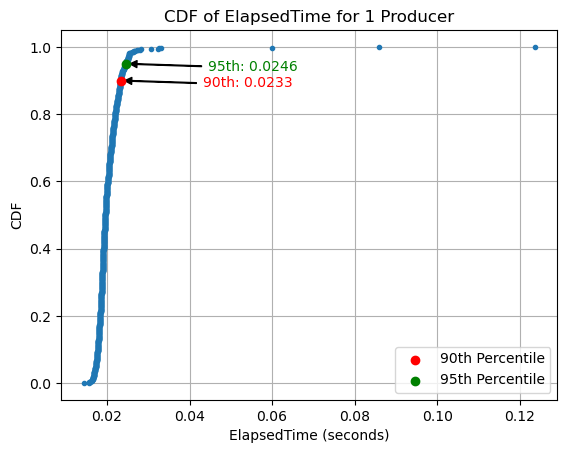

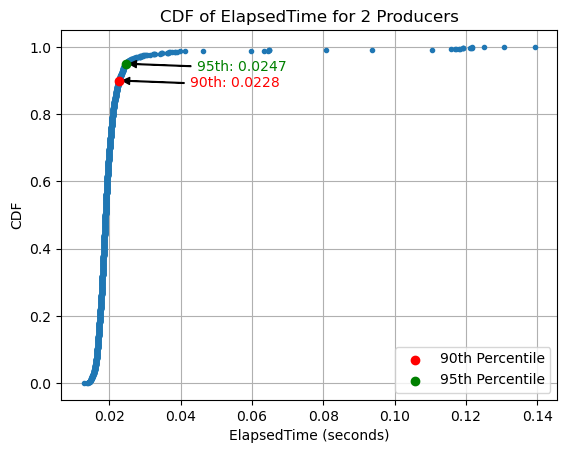

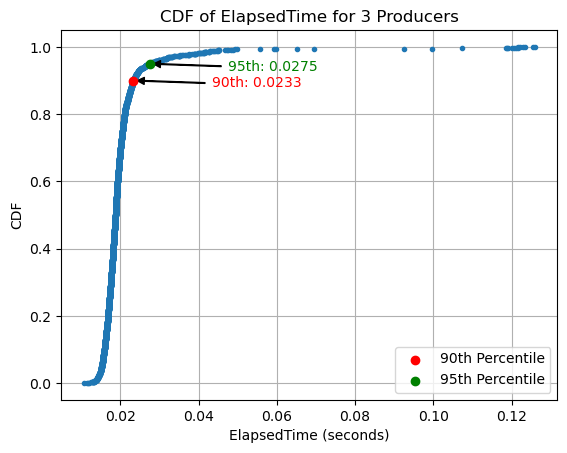

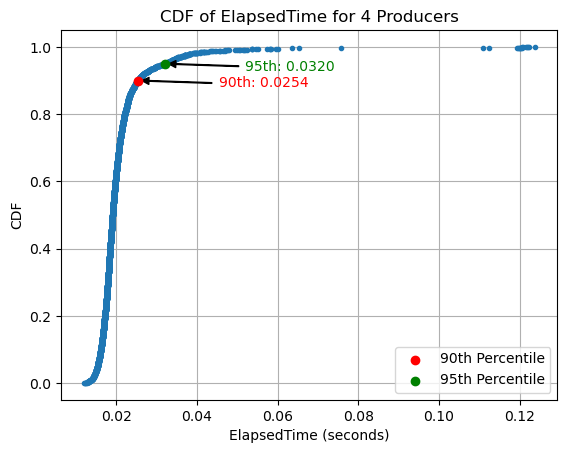

In [41]:
# Create CDF for every number of producers from 1-4
for num_producers in range(1, 5):
    files = []
    for i in range(1, num_producers + 1):
        files.append(f'./{num_producers}_producer/elapsed_times_{num_producers}_{i}.txt')
    plotCDF(files, num_producers)

### Results

We can see that as we added more producers, thus increasing the workload of the ml Server VM, the tail latency generally increased.

From 1 to 2 producers there is no significant increase, where the 95th percentile increased from 0.0246 to 0.0247, and the 90th percentile actually decreased from 0.0233 to 0.0228 (although this is likely due to natural variance).

From 2 to 3 producers there is a slight increase, as the 95th percentile increased significantly from 0.0247 to 0.0275, and the 90th percentile increased back up to 0.0233.

From 3 to 4, there is a significant increase in both, with the 95th percentile making a much larger leap to 0.0320, and the 90th percentile increasing to 0.0254.

From this information, we can conclude that as the workload increases, tail latencies generally increase. In addition, the latencies of the higher percentiles (closer to the end of the tail) will increase sooner, and at a much larger rate than latencies further from the tail.